In [1]:
import os
import duckdb
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

%load_ext sql

from dotenv import load_dotenv

load_dotenv()

DB_PATH = Path(".").absolute().parent / Path(os.getenv("SILVER_DUCKDB_PATH", ""))

TMP_DIR = "/tmp/duckdb_tmp"  # make sure it exists

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

conn = duckdb.connect(DB_PATH)

conn.execute(f"SET temp_directory='{TMP_DIR}'")
conn.execute("SET memory_limit='50GB'")
conn.execute("SET threads=1")
conn.execute("SET preserve_insertion_order=false")

plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (6, 4)

%sql conn --alias duck

Tip: You may define configurations in /home/c-cc2016/ra173608/tramita/pyproject.toml or /home/c-cc2016/ra173608/.jupysql/config.

Did not find user configurations in /home/c-cc2016/ra173608/tramita/pyproject.toml.

In [2]:
%%sql
select * from autores_camara where uri = '';

Running query in 'duck'

id_autor,cod_tipo,uri,ordem_assinatura,proponente,id_proposicao,year
6614,20000,,1,True,2244282,2020
6631,20000,,1,True,2244299,2020
6632,20000,,1,True,2244300,2020
6633,20000,,1,True,2244301,2020
6674,20000,,1,True,2244343,2020
6675,20000,,1,True,2244344,2020
6740,20000,,1,True,2244411,2020
6757,20000,,1,True,2244428,2020
6759,20000,,1,True,2244430,2020
6760,20000,,1,True,2244431,2020


In [3]:
%%sql
SELECT
  id_proposicao,
  uri,
  CASE
    WHEN REGEXP_FULL_MATCH(uri, '.*/deputados/[0-9]+$') THEN 'deputado'
    WHEN REGEXP_FULL_MATCH(uri, '.*/orgaos/[0-9]+$')    THEN 'orgao'
    ELSE 'unknown'
  END AS author_type,
  REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 1) AS uri_kind,      -- 'deputados' or 'orgaos'
  REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 2) AS author_id_str, -- numeric id as text
  TRY_CAST(REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 2) AS BIGINT) AS author_id_num
FROM autores_camara
WHERE uri <> ''
LIMIT 50;


Running query in 'duck'

id_proposicao,uri,author_type,uri_kind,author_id_str,author_id_num
15009,https://dadosabertos.camara.leg.br/api/v2/deputados/73538,deputado,deputados,73538,73538
15532,https://dadosabertos.camara.leg.br/api/v2/deputados/73910,deputado,deputados,73910,73910
15749,https://dadosabertos.camara.leg.br/api/v2/deputados/74316,deputado,deputados,74316,74316
15990,https://dadosabertos.camara.leg.br/api/v2/orgaos/262,orgao,orgaos,262,262
16481,https://dadosabertos.camara.leg.br/api/v2/orgaos/78,orgao,orgaos,78,78
16969,https://dadosabertos.camara.leg.br/api/v2/orgaos/78,orgao,orgaos,78,78
17563,https://dadosabertos.camara.leg.br/api/v2/deputados/73788,deputado,deputados,73788,73788
17823,https://dadosabertos.camara.leg.br/api/v2/deputados/74671,deputado,deputados,74671,74671
17915,https://dadosabertos.camara.leg.br/api/v2/orgaos/78,orgao,orgaos,78,78
18420,https://dadosabertos.camara.leg.br/api/v2/deputados/73458,deputado,deputados,73458,73458


In [4]:
%%sql
CREATE OR REPLACE VIEW camara_authors AS
SELECT
  CAST(id_proposicao AS BIGINT) AS id_proposicao,
  REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 1) AS uri_kind,
  TRY_CAST(REGEXP_EXTRACT(uri, '.*/(deputados|orgaos)/([0-9]+)$', 2) AS BIGINT) AS author_id_num
FROM autores_camara
WHERE uri IS NOT NULL;

Running query in 'duck'

Count


In [5]:
%%sql
SELECT * FROM camara_authors LIMIT 10;

Running query in 'duck'

id_proposicao,uri_kind,author_id_num
15009,deputados,73538
15532,deputados,73910
15749,deputados,74316
15990,orgaos,262
16481,orgaos,78
16969,orgaos,78
17563,deputados,73788
17823,deputados,74671
17915,orgaos,78
18420,deputados,73458


In [6]:
%%sql
WITH orphan_ids AS (
  SELECT DISTINCT a.author_id_num AS id_deputado
  FROM camara_authors a
  LEFT JOIN deputados_camara d
    ON d.id_deputado = a.author_id_num
  WHERE a.uri_kind = 'deputados' AND d.id_deputado IS NULL
),
cnt AS (SELECT COUNT(*) AS n FROM orphan_ids)
-- returns 1 if OK; raises divide-by-zero error if any orphan exists
SELECT 1 / (CASE WHEN n = 0 THEN 1 ELSE 0 END) AS ok_zero_orphans
FROM cnt;

Running query in 'duck'

ok_zero_orphans
1.0


In [7]:
%%sql
WITH orphan_ids AS (
  SELECT DISTINCT a.author_id_num AS id_orgao
  FROM camara_authors a
  LEFT JOIN orgaos_camara o
    ON o.id_orgao = a.author_id_num
  WHERE a.uri_kind = 'orgaos' AND o.id_orgao IS NULL
),
cnt AS (SELECT COUNT(*) AS n FROM orphan_ids)
-- returns 1 if OK; raises divide-by-zero error if any orphan exists
SELECT 1 / (CASE WHEN n = 0 THEN 1 ELSE 0 END) AS ok_zero_orphans
FROM cnt;

WITH orphan_ids AS (
  SELECT DISTINCT a.author_id_num AS id_orgao
  FROM camara_authors a
  LEFT JOIN orgaos_camara o
    ON o.id_orgao = a.author_id_num
  WHERE a.uri_kind = 'orgaos' AND o.id_orgao IS NULL
)
SELECT * FROM orphan_ids LIMIT 100;

Running query in 'duck'

id_orgao
262
5996
6502
6726
81
537485
537337
537914
537742
538202


In [8]:
%%sql
-- IDs referenced by the bipartite view but missing in your current table
CREATE OR REPLACE VIEW missing_orgaos AS
WITH refs AS (
  SELECT DISTINCT author_id_num AS id_orgao
  FROM camara_authors
  WHERE uri_kind = 'orgaos'
),
have AS (
  SELECT DISTINCT id_orgao FROM orgaos_camara
)
SELECT r.id_orgao
FROM refs r
LEFT JOIN have h ON h.id_orgao = r.id_orgao
WHERE h.id_orgao IS NULL;


Running query in 'duck'

Count


In [9]:
%%sql
SELECT COUNT(*) AS n_missing FROM missing_orgaos;

Running query in 'duck'

n_missing
62


In [10]:
missing = conn.execute("SELECT id_orgao FROM missing_orgaos").df().id_orgao.to_list()
missing

[262,
 5996,
 6502,
 6726,
 81,
 537485,
 537337,
 537914,
 537742,
 538202,
 101347,
 57,
 101489,
 102133,
 102346,
 371,
 80,
 6914,
 382,
 275,
 101131,
 277,
 9140,
 537484,
 537487,
 537731,
 537931,
 79,
 60,
 6994,
 479,
 5498,
 6415,
 9071,
 82,
 537273,
 271,
 538490,
 538297,
 101772,
 6987,
 266,
 476,
 276,
 279,
 284,
 5495,
 5364,
 5560,
 6115,
 6281,
 6462,
 6697,
 537127,
 6303,
 537389,
 101798,
 537939,
 10119,
 539426,
 539461,
 101582]

In [11]:
import asyncio
import httpx

async def fetch_orgao(orgao_id: int, sem: asyncio.Semaphore, client: httpx.AsyncClient):
    async with sem:
        for _ in range(10):
            try:
                print(orgao_id)
                response = await client.get(f"https://dadosabertos.camara.leg.br/api/v2/orgaos/{orgao_id}")
                response.raise_for_status()
                data = response.json()
                return data
            except Exception:
                print(f"Retrying {orgao_id}...")
                await asyncio.sleep(3)
    
sem = asyncio.Semaphore(10)

async with httpx.AsyncClient() as client:
    tasks = [fetch_orgao(oid, sem, client) for oid in missing]
    result = await asyncio.gather(*tasks, return_exceptions=True)

262
5996
6502
6726
81
537485
537337
537914
537742
538202
101347
57
101489
102133
102346
371
80
6914
382
275
101131
277
9140
537484
537487
537731
537931
79
60
6994
479
5498
6415
9071
82
537273
271
538490
538297
101772
6987
266
476
276
279
284
5495
5364
5560
6115
6281
6462
6697
537127
6303
537389
101798
537939
10119
539426
539461
101582


In [12]:
result[0]

{'dados': {'id': 262,
  'uri': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/262',
  'sigla': 'CPMI',
  'nome': 'COMISSÃO MISTA',
  'apelido': 'CPMI',
  'codTipoOrgao': 20,
  'tipoOrgao': 'Comissão Parlamentar Mista de Inquérito',
  'nomePublicacao': 'CPMI',
  'nomeResumido': None,
  'dataInicio': None,
  'dataInstalacao': None,
  'dataFim': None,
  'dataFimOriginal': None,
  'casa': '',
  'sala': None,
  'urlWebsite': None},
 'links': [{'rel': 'self',
   'href': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/262'}]}

In [13]:
rows = []
for r in result:
    d = r['dados']
    rows.append({
        'id_orgao': int(d['id']),
        'nome': d['nome'],
        'cod_tipo_orgao': int(d['codTipoOrgao']),
        'uri': d['uri'],
        'year_snapshot': 2020,
        "rn": 1,
    })

In [14]:
df = pd.DataFrame(rows).drop_duplicates(subset=['id_orgao'])

In [15]:
df.to_csv("outputs/orgaos_hotfix_2025-09-23.csv", index=False)

In [16]:
%%sql
-- Create/replace a hotfix table from the CSV
DROP TABLE IF EXISTS orgaos_camara_hotfix;
CREATE TABLE orgaos_camara_hotfix AS
SELECT * FROM read_csv_auto('outputs/orgaos_hotfix_2025-09-23.csv', header=True);

-- Create a unified view that prefers your original rows, then fills with hotfix
CREATE OR REPLACE VIEW orgaos_camara_all AS
WITH base AS (
  SELECT * FROM orgaos_camara
),
fix AS (
  SELECT * FROM orgaos_camara_hotfix
  WHERE id_orgao NOT IN (SELECT id_orgao FROM base)
)
SELECT * FROM base
UNION ALL
SELECT * FROM fix;


Running query in 'duck'

Count


In [17]:
%%sql
SELECT * FROM orgaos_camara LIMIT 5;

Running query in 'duck'

id_orgao,nome,cod_tipo_orgao,uri,year_snapshot,rn
201,COMISSÃO DO TRABALHO,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/201,2023,1
218,COMISSÃO DE CONSTITUIÇÃO E JUSTIÇA,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/218,2023,1
5306,"Dispõe sobre o Conselho de Altos Estudos e Avaliação Tecnológica, de que trata o artigo 275 do Regimento Interno.",11,https://dadosabertos.camara.leg.br/api/v2/orgaos/5306,0,1
5437,"Comissão Especial destinada a apreciar e proferir parecer à Proposta de Emenda à Constituição nº 57-A, de 1999, que "" altera o art. 159 para instituir o Fundo Nacional de Desenvolvimento do Semi-Árido e prevê suas fontes de recursos"".",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/5437,2023,1
5604,"Altera a Legislação Tributária Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5604,0,1


In [18]:
%%sql

SELECT * FROM proposicoes_camara LIMIT 10;

Running query in 'duck'

id_proposicao,sigla_tipo,numero,ano,ementa,uri,year_snapshot
15009,PL,70,1995,Dispõe sobre intervenções cirúrgicas que visem à alteração de sexo e dá outras providências.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/15009,2020
15532,PL,505,1991,"Revoga a alínea ""l"" do art. 20 do Decreto-lei nº 73, de 21 de novembro de 1966, extinguindo o Seguro Obrigatório de Veículos Automotores",https://dadosabertos.camara.leg.br/api/v2/proposicoes/15532,2020
15749,PL,693,1999,"Altera a Lei nº 8.245, de 18 de outubro de 1991, Lei do Inquilinato, nos dispositivos que menciona.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/15749,2020
15990,PL,887,1991,Cria salvaguardas para a tecnologia no campo nuclear. (AUTOR: Comissão Parlamentar Mista de Inquérito Destinada a Apurar o Programa Nuclear Paralelo),https://dadosabertos.camara.leg.br/api/v2/proposicoes/15990,2020
16481,PL,1258,1995,Disciplina o inciso XII do art. 5º da Constituição Federal e dá outras providências.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/16481,2020
16969,PL,1610,1996,"Dispõe sobre a exploração e o aproveitamento de recursos minerais em terras indígenas, de que tratam os arts. 176, parágrafo 1º, e 231, parágrafo 3º, da Constituição Federal.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/16969,2020
17563,PL,2051,1996,"Dispõe sobre a assistência médica, hospitalar e educacional gratuita aos ex-combatentes e a seus dependentes, prevista no inciso IV do artigo 53 do Ato das Disposições Constitucionais Transitórias.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17563,2020
17823,PL,2231,1999,"Obriga os responsáveis por ""sites"" provedores de informações na Internet a fornecer classificação indicativa do conteúdo veiculado.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17823,2020
17915,PL,2295,2000,"Dispõe sobre a jornada de trabalho dos Enfermeiros, Técnicos e Auxiliares de Enfermagem.",https://dadosabertos.camara.leg.br/api/v2/proposicoes/17915,2020
18420,PL,2639,2000,Dispõe sobre a atividade de curta duração em propriedades rurais.,https://dadosabertos.camara.leg.br/api/v2/proposicoes/18420,2020


In [19]:
%%sql

SELECT * FROM deputados_camara LIMIT 10;

Running query in 'duck'

id_deputado,nome_civil,uri,year_snapshot,rn
62926,REINALDO SANTOS E SILVA,https://dadosabertos.camara.leg.br/api/v2/deputados/62926,2020,1
66828,FAUSTO RUY PINATO,https://dadosabertos.camara.leg.br/api/v2/deputados/66828,2020,1
73439,Carlos Nelson Bueno,https://dadosabertos.camara.leg.br/api/v2/deputados/73439,2023,1
73463,OSMAR JOSÉ SERRAGLIO,https://dadosabertos.camara.leg.br/api/v2/deputados/73463,2020,1
73464,BERNARDINO BARRETO DE OLIVEIRA,https://dadosabertos.camara.leg.br/api/v2/deputados/73464,2021,1
73472,GERVÁSIO JOSÉ DA SILVA,https://dadosabertos.camara.leg.br/api/v2/deputados/73472,2020,1
73483,LUIS CARLOS HEINZE,https://dadosabertos.camara.leg.br/api/v2/deputados/73483,2020,1
73486,DARCI POMPEO DE MATTOS,https://dadosabertos.camara.leg.br/api/v2/deputados/73486,2020,1
73507,ROSILDA DE FREITAS,https://dadosabertos.camara.leg.br/api/v2/deputados/73507,2022,1
73545,EUSTÁQUIO LUCIANO ZICA,https://dadosabertos.camara.leg.br/api/v2/deputados/73545,2021,1


In [20]:
%%sql

SELECT * FROM orgaos_camara_all LIMIT 10;

Running query in 'duck'

id_orgao,nome,cod_tipo_orgao,uri,year_snapshot,rn
201,COMISSÃO DO TRABALHO,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/201,2023,1
218,COMISSÃO DE CONSTITUIÇÃO E JUSTIÇA,2,https://dadosabertos.camara.leg.br/api/v2/orgaos/218,2023,1
5306,"Dispõe sobre o Conselho de Altos Estudos e Avaliação Tecnológica, de que trata o artigo 275 do Regimento Interno.",11,https://dadosabertos.camara.leg.br/api/v2/orgaos/5306,0,1
5437,"Comissão Especial destinada a apreciar e proferir parecer à Proposta de Emenda à Constituição nº 57-A, de 1999, que "" altera o art. 159 para instituir o Fundo Nacional de Desenvolvimento do Semi-Árido e prevê suas fontes de recursos"".",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/5437,2023,1
5604,"Altera a Legislação Tributária Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5604,0,1
5942,"Altera dispositivos da Lei nº 8.745, de 9 de dezembro de 1993, e da Lei nº 10.470, de 25 de junho de 2002, cria cargos efetivos, cargos comissionados e gratificações no âmbito da Administração Pública Federal, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5942,0,1
5956,"Altera as Leis nºs. 8.248, de 23 de outubro de 1991, 8.387, de 30 de dezembro de 1991, e 10.176, de 11 de janeiro de 2001, dispondo sobre a capacitação e competitividade do setor de tecnologia da informação, e dá outras providências.",9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5956,0,1
5957,Dispõe sobre a contribuição para o Programa de Integração Social e de Formação do Patrimônio do Servidor Público - PIS/PASEP e da Contribuição para Seguridade Social - COFINS devidas pelas sociedades cooperativas em geral.,9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5957,0,1
5986,Cria a Carreira de Agente Penitenciário Federal no Quadro de Pessoal do Departamento de Polícia Federal e dá outras providências.,9,https://dadosabertos.camara.leg.br/api/v2/orgaos/5986,0,1
8669,"Comissão Especial destinada a proferir parecer à Proposta de Emenda à Constituição nº 53-A, de 2007, do Sr. Jofran Frejat, que ""dá nova redação ao § 3º do Art. 39 da Constituição Federal"" (garante ao servidor de cargo em comissão de livre nomeação e exoneração, direito a aviso prévio, seguro desemprego, FGTS, entre outros)",3,https://dadosabertos.camara.leg.br/api/v2/orgaos/8669,2021,1


In [21]:
%%sql
SELECT * FROM camara_authors LIMIT 10;

Running query in 'duck'

id_proposicao,uri_kind,author_id_num
15009,deputados,73538
15532,deputados,73910
15749,deputados,74316
15990,orgaos,262
16481,orgaos,78
16969,orgaos,78
17563,deputados,73788
17823,deputados,74671
17915,orgaos,78
18420,deputados,73458


In [22]:
%%sql
-- Deputados: any referenced in camara_authors but missing in deputados_camara
SELECT DISTINCT a.author_id_num AS missing_deputado_id
FROM camara_authors a
LEFT JOIN deputados_camara d ON d.id_deputado = a.author_id_num
WHERE a.uri_kind = 'deputados' AND d.id_deputado IS NULL;


Running query in 'duck'

missing_deputado_id


In [23]:
%%sql
-- Órgãos: any referenced in camara_authors but missing in orgaos_camara_all
SELECT DISTINCT a.author_id_num AS missing_orgao_id
FROM camara_authors a
LEFT JOIN orgaos_camara_all o ON o.id_orgao = a.author_id_num
WHERE a.uri_kind = 'orgaos' AND o.id_orgao IS NULL;


Running query in 'duck'

missing_orgao_id


In [24]:
# Get the congressmen and labels

deps_df = conn.execute("SELECT * FROM deputados_camara").df()
deps_df['label'] = deps_df['nome_civil']
deps_df['tag'] = deps_df['id_deputado'].apply(lambda v: f"D:{v}")
deps_df = deps_df[['tag', 'label']]

# Get the entities and labels

orgs_df = conn.execute("SELECT * FROM orgaos_camara_all").df()
orgs_df['label'] = orgs_df['nome']
orgs_df['tag'] = orgs_df['id_orgao'].apply(lambda v: f"O:{v}")
orgs_df = orgs_df[['tag', 'label']]


In [25]:

# Compile a DF of just labels

labels_df = pd.concat([orgs_df, deps_df]).set_index('tag', drop=True)
labels_df.columns = ['auth_label']

# Build the propositions DF and labels

props_df = conn.execute("SELECT * FROM proposicoes_camara").df()
props_df['prop_label'] = props_df.apply(lambda r: f"{r['sigla_tipo']} {r['numero']}/{r['ano']}", axis=1)
props_df = props_df.set_index('id_proposicao', drop=True)
props_df = props_df[['prop_label']]


# Link with edge table

df = conn.execute("""SELECT * FROM camara_authors""").df()

df['prop_tag'] = df['id_proposicao'].apply(lambda v: f"P:{v}")
df['auth_tag'] = df.apply(
    lambda r: f"D:{r['author_id_num']}" if r['uri_kind'] == 'deputados'
              else f"O:{r['author_id_num']}",
    axis=1
)

df = df.join(props_df, how='left', on='id_proposicao').join(labels_df, how='left', on='auth_tag')

In [26]:
%%sql
SELECT * FROM camara_authors WHERE id_proposicao = 2198803;

Running query in 'duck'

id_proposicao,uri_kind,author_id_num


In [27]:
# drop phantom NAs
df = df[~df['auth_tag'].str.contains("<")]

In [28]:
df[['prop_tag', 'auth_tag']].to_csv(OUT_DIR / "camara_tripartite_edges.csv", index=False)

In [29]:
prop_node_df = df[['prop_tag', 'prop_label']].drop_duplicates()
prop_node_df['type'] = "proposicao"
prop_node_df.columns = ['tag', 'label', 'type']
prop_node_df.head()

,tag,label,type
0,P:15009,PL 70/1995,proposicao
1,P:15532,PL 505/1991,proposicao
2,P:15749,PL 693/1999,proposicao
3,P:15990,PL 887/1991,proposicao
4,P:16481,PL 1258/1995,proposicao


In [30]:
auth_node_df = df[['auth_tag', 'auth_label']].drop_duplicates()
auth_node_df['type'] = auth_node_df['auth_tag'].apply(lambda v: "deputado" if v[0] == "D" else "orgao")
auth_node_df.columns = ['tag', 'label', 'type']
auth_node_df.head()

,tag,label,type
0,D:73538,JOSÉ DE CASTRO COIMBRA,deputado
1,D:73910,PAULO RENATO PAIM,deputado
2,D:74316,JOÃO HENRIQUE DE ALMEIDA SOUSA,deputado
3,O:262,COMISSÃO MISTA,orgao
4,O:78,Senado Federal,orgao


In [31]:
node_df = pd.concat([auth_node_df, prop_node_df]).reset_index(drop=True)
node_df

,tag,label,type
0,D:73538,JOSÉ DE CASTRO COIMBRA,deputado
1,D:73910,PAULO RENATO PAIM,deputado
2,D:74316,JOÃO HENRIQUE DE ALMEIDA SOUSA,deputado
3,O:262,COMISSÃO MISTA,orgao
4,O:78,Senado Federal,orgao
...,...,...,...
82028,P:2525011,PL 2833/2025,proposicao
82029,P:2529248,PL 3127/2025,proposicao
82030,P:2531284,PL 3194/2025,proposicao
82031,P:2539409,EMC 1/2025,proposicao


In [32]:
node_df.to_csv(OUT_DIR / "camara_tripartite_nodes.csv", index=False)

In [33]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import date
from pathlib import Path

sns.set_style("darkgrid")
NODES_CSV = "outputs/camara_tripartite_nodes.csv"       # <-- change
EDGES_CSV = "outputs/camara_tripartite_edges.csv"      # <-- change
OUT_DIR   = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [34]:
nodes_df = pd.read_csv(NODES_CSV)
edges_df = pd.read_csv(EDGES_CSV)

In [35]:
G = nx.Graph()

for _, r in nodes_df.iterrows():
    G.add_node(
        r['tag'],
        label=r['label'],
        ntype=r['type'],
    )

In [36]:
for _, r in edges_df.iterrows():
    p, a = r['prop_tag'], r['auth_tag']
    G.add_edge(a, p, etype="autoria")

In [37]:
G.number_of_nodes(), G.number_of_edges()

(82033, 144887)

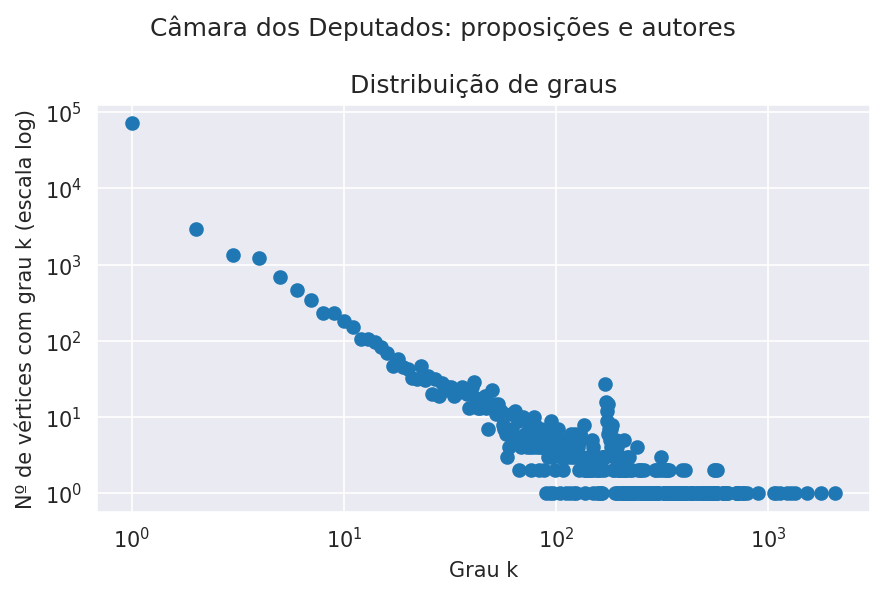

In [38]:
degree_dist = Counter(dict(G.degree).values())
xs = sorted(degree_dist.keys())
ys = [degree_dist[x] for x in xs]
plt.figure(figsize=(6,4))
plt.scatter(xs, ys)
plt.xlabel("Grau k")
plt.ylabel("Nº de vértices com grau k (escala log)")
plt.xscale("log")
plt.yscale("log")
plt.suptitle("Câmara dos Deputados: proposições e autores")
plt.title("Distribuição de graus")
plt.tight_layout()
plt.show()

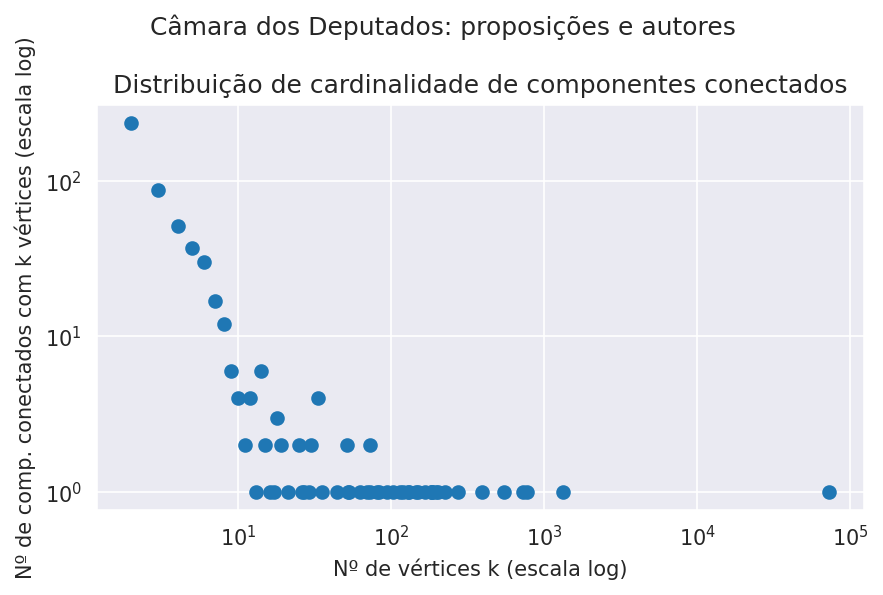

In [39]:
ccs = list(nx.connected_components(G))
cc_sizes = [len(cc) for cc in ccs]
cc_size_dist = Counter(cc_sizes)
xs = sorted(cc_size_dist.keys())
ys = [cc_size_dist[x] for x in xs]
plt.figure(figsize=(6,4))
plt.scatter(xs, ys)
plt.xlabel("Nº de vértices k (escala log)")
plt.ylabel("Nº de comp. conectados com k vértices (escala log)")
plt.xscale("log")
plt.yscale("log")
plt.suptitle("Câmara dos Deputados: proposições e autores")
plt.title("Distribuição de cardinalidade de componentes conectados")
plt.tight_layout()
plt.show()

In [ ]:
V = G.number_of_nodes()
E = G.number_of_edges()
k = 2 * V / E
print(f"|V| = {V}")
print(f"|E| = {E}")
print(f"<k> = {k}")

# TODO: separar grau médio por tipo de nó (autores por proposição, proposições por deputado/órgão)
# TODO: procurar outliers (p. ex. muitas proposições da PR ou SF)


|V| = 82033
|E| = 144887
<k> = 1.132372124483218
